# Assignment 2: Multi-View Geometry

### Comment: most of the written problems are designed to help with the coding part (structure-from-motion). Thus, they should be solved first. Your coding part will require figuring out how to work with numpy arrays (e.g. slicing, broadcasting). If you are new to numpy, this could be tricky. I can recommend working on small test cases. For debugging, print arrays before and after slicing (etc.) to verify that the result is correct. 

## Problem 1
### Prove that epipoles in two images obtained by the same camera during "translating" motion (no rotation) have exactly the same location in both images.

Solution:

## Problem 2
### Assuming a $calibrated$ camera (that is, $K=I$) and its two views corresponding to projection matrices $P_1=[I|0]$ and $P_2=[R|T]$ w.r.t. some world coordinate system, show formulas for coordinates of the following 3D points (in the same world coordinate system):

#### (a) optical center for the first view: $C_1=$ 
#### (b) image center for the first view: $Q_1=$ 
#### (c) optical center for the second view: $C_2=$ 
#### (d) image center for the second view: $Q_2=$ 

## Problem 3
### Using the same set up as in problem 2, show formulas for normalized coordinates of the following image points:

#### (a) epipole in the first camera image: $e_1=$
#### (b) epipole in the second camera image: $e_2=$

## Problem 4 (homogeneous and non-homogeneous line representations)
###  Lines in 2D images can be represented "homogeneously" as 3-vectors $l=[l_1,l_2,l_3]^T$ that give equation $l^T x=0$ for homogeneous points $x=[x_1,x_2,x_3]^T \;\in {\cal P}^2$ forming a line. Given $l$, what are the values of scalar parameters $a$, $b$ in the line equation $u=av+b$ for the same 2D points based on their regular (nonhomogeneous) representation $(u,v)=(\frac{x_1}{x_3},\frac{x_2}{x_3})$ in ${\cal R}^2$? 
#### $a=$
#### $b=$

## Problem 5 (epipolar lines in normalized and non-normalized images)
### Given a matrix of intrinsic camera parameters $K$ and essential matrix $E$ between two views (A) and (B) such that $x_A^T E x_B=0$ for any corresponding points, write expressions for the following: 

#### (a) given homogeneous normalized point $x^{n}_B$ in image B, specify 3-vector $l_A^n$ describing the corresponding epipolar line of normalized points in image A:
####   $l_A^n=$
#### (b) given homogeneous normalized point $x^{n}_A$ in image A, specify 3-vector $l_B^n$ describing the corresponding epipolar line of normalized points in image B:
####   $l_B^n=$
#### (c) assuming line (3-vector) $l^n$ of normalized image points, what is a 3-vector representation $l$ for the line formed by the corresponding points on the real (unnormalized) camera image:
#### $l=$

## Problem 6 (least squares for triangulation)
### Describe your approach to triangulating two matched feature points $x_a=[u_a,v_a,1]^T$ and $x_b=[u_b,v_b,1]^T$ in two views with given projection matrices $P_a$ and $P_b$. You should find 3D point $X=[X_1,X_2,X_3,1]^T$ and two scalars $w_a,w_b$ such that $P_a X\approx w_a x_a$ and $P_b X\approx w_b x_b$.  Be specific as you will need this for your programming part below. Use notation $M[i]$ to denote the $i$-th row vector of matrix $M$.
### You should use the first approach described for homograpy estimation in topic 6. In particualr, you can formulate the problem as $AX\approx 0$, define elements of $4x4$ matrix $A$, convert the problem to an overdetermined system of 4 linear equations $A_{1:3}[X_1,X_2,X_3]^T \approx - A_{4}$, and specify its solution minimizing the sum of squared errors.
### Can you characterize geometrically the case when your solution satisfies $A_{1:3}[X_1,X_2,X_3]^T = - A_{4}$ exactly?

Solution:

## Probelm 7 (the programming part)
# Structure from Motion 
#### NOTE: Steps 0-3 and 10 are given, other steps needs to be implemented.
### Step 0: Loading two camera views and camera's intrinsic matrix $K$ 

<IPython.core.display.Javascript object>


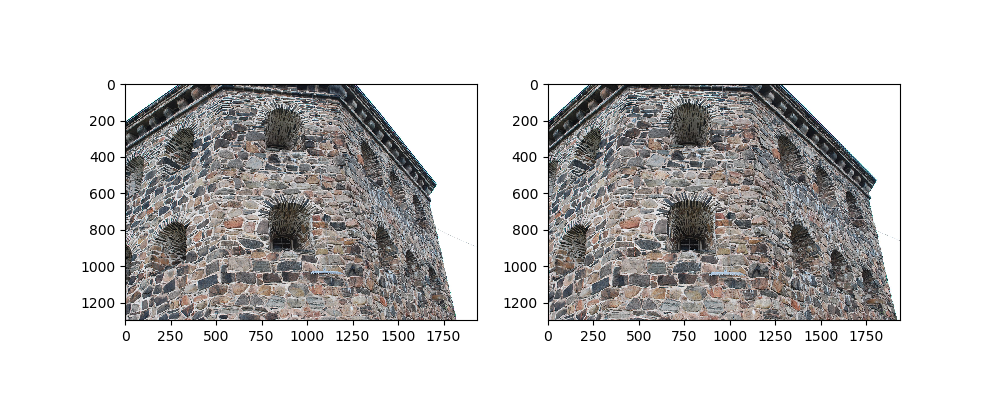

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/kronan1.jpg")
imR = image.imread("images/kronan2.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

K = 1.0e+03 * np.array([[2.3940, -0.0000,    0.9324],
                        [     0,  2.3981,    0.6283],
                        [     0,       0,    0.0010]])


plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

### Step 1: Feature detection (e.g. corners) 

the number of features in images 1 and 2 are  1576 and  1661


<IPython.core.display.Javascript object>


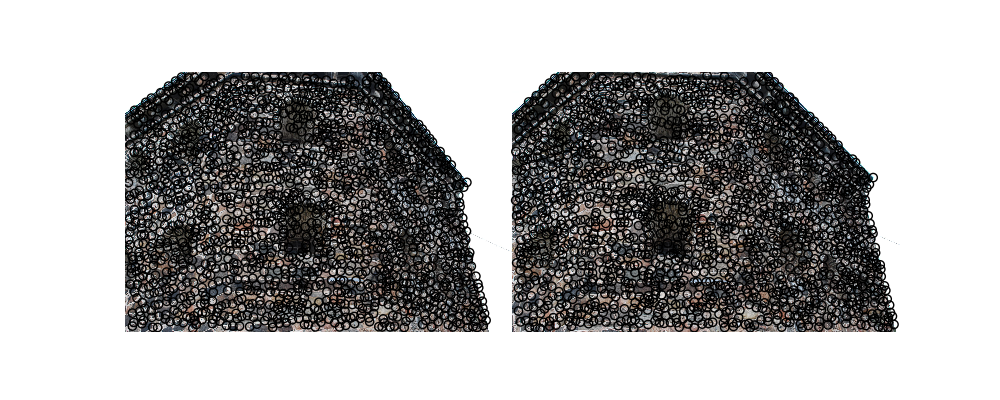

In [2]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

### Step 2: Feature matching (e.g. BRIEF descriptor, a variant of SURF, SIFT, etc)

the number of matches is 982


<IPython.core.display.Javascript object>


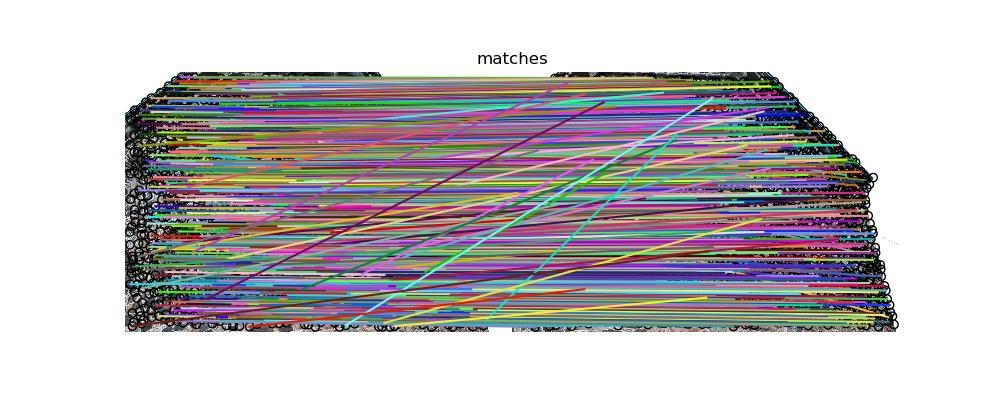

In [3]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

### Step 3: Fundamental Matrix estimation using RANSAC

the number of inliers is 172


<IPython.core.display.Javascript object>


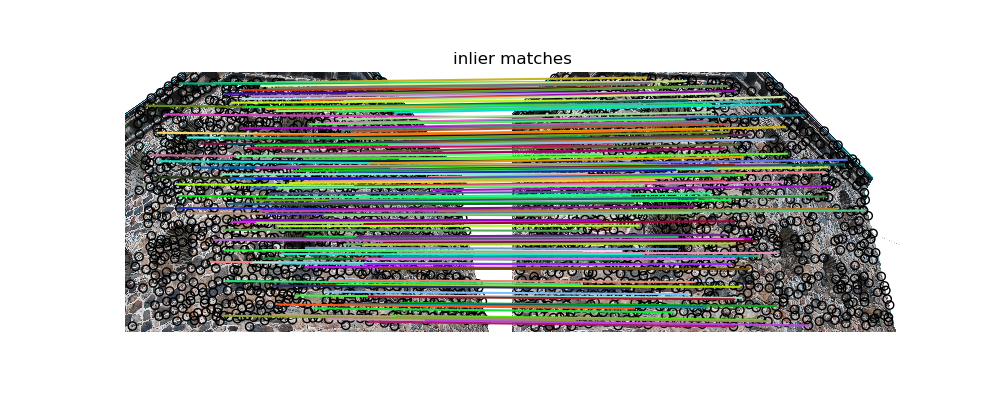

In [4]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

### singular values for F

In [5]:
F = F_trans.params
Uf,Sf,Vf = la.svd(F, full_matrices=False)
print (Sf)

[8.20225913e-02 6.43202658e-05 7.91044012e-20]


### Step 4: Epipolar lines from F

In [ ]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for F
ind_sample = np.random.choice(ind[F_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(4,figsize = (10, 4))
ax41 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax42 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homoheneous 3-vectors l2 representing lines l2 x  = 0) 
# a. create an array of points sampled in images 1 and 2  
# b. create an array of homogeneous points sampled in images 1 and 2 
# c. create an array of the corresponding epipolar lines in images 1 and 2 


# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# see Assignment 1 (line fitting part 1) for inspiration on how to visualize lines
# use ax41.plot and ax42.plot 


plt.show()

### Step 5: Camera Normalization and Essential Matrix estimation using RANSAC

In [ ]:
# normalization of points in two images using K (intrinsic parameters) e.g. in the following three steps
# a. convert original points to homogeneous 3-vectors (append "1" as a 3rd coordinate using np.append function)
# b. transform the point by applying the inverse of K
# c. convert homogeneous 3-vectors to 2-vectors (in R2)
n_ptsL =
n_ptsR = 

# robustly estimate essential matrix using normalized points and RANSAC
E_trans, E_inliers = ransac((n_ptsL, n_ptsR), EssentialMatrixTransform, min_samples=8, residual_threshold=0.0005, max_trials=5000)
num_inliers = np.sum(E_inliers)
print ('the number of inliers is {:2d}'.format(num_inliers))

ind = np.ogrid[:n_ptsL.shape[0]]
EmatchesRansac = np.column_stack((ind[E_inliers],ind[E_inliers]))

fig = plt.figure(5,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, EmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

### singular values for E
#### Hint: function $svd$ from $linalg$ returns transpose $V^T$, not $V$.  

In [ ]:
E = E_trans.params
Ue,Se,Ve = la.svd(E)
print (Se)

### Step 6: Epipolar Lines from E 

In [ ]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for E
ind_sample = np.random.choice(ind[E_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(6,figsize = (10, 4))
ax61 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax62 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homoheneous 3-vectors l2 representing lines l2 x  = 0) 
# a. create an array of normalized points sampled in image 1 
# b. create an array of homogeneous normalized points sampled in image 1 
# c. create an array of the corresponding (uncalibrated) epipolar lines in image 2 
#n_ptsL_sample = n_ptsL[ind_sample,:]
#n_ptsR_sample = n_ptsR[ind_sample,:]


# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# use ax61.plot and ax62.plot 

plt.show()

### Step 7: Camera rotation and translation (four solutions)

#### Factorize essential matrix $E=[T]_x R$ where $R$ is rotation and $T$ is a translation. Find solutions $R_1$, $R_2$ and $T_1$, $T_2$. Use camera 1 for world coordinates. Define projection matrix for camera 1 as $P_w = [I|0]$ and compute four projection matrices for the second camera $P_a$, $P_b$, $P_c$, $P_d$.
#### Hint 1: for array multiplication use $dot$ or $matmul$, never $*$. 
#### Hint 2: function  $svd$  from  $linalg$  returns  $V^T$ rather than $V$ (the 2nd orthogonal matrix in svd decomposition $E = USV^T$).
#### Warning: remember that python uses 0 as a starting index for the rows or columns in arrays. For example, $A[0]$ denotes the first row of matrix $A$, while $P_w[2]$ stands for the 3rd row of the corresponding projection matrix and $E[:,[1]]$ is the second column of the essential matrix. 


In [ ]:
R1 = 
R2 = 
T1 =   
T2 = 

# first camera matrix
Pw = 

# four possible matrices for the second camera
Pa = 
Pb = 
Pc = 
Pd = 

### Step 8: Triangulation (four solutions).
#### Implement homogeneous least square solver (you can use $svd$ function) and use it for each matching pair of features in left and right images to find the corresponding 3D point. Make sure to use normalized coordinates for image points. Show four solutions corresponding to cameras $P_a$, $P_b$, $P_c$, $P_d$. Specify, which solution has 3D points in front of both cameras.
#### Project 3D points onto each camera, convert to uncalibrated coordinates and display these projected points (use red) together with the original features (use blue). Observe if the are red and blue points are close in each image.

In [ ]:
# Select normalized coordinates for matched features that are inliers for essential matrix E. 
# Form matrix A in equation AX=0 where X represent 4 vectors (homogeneous representation of 3D point).
# Use your solution for Problem 6.
# Each camera (projection matrix P) will define its own A  

# HINT: to keep it simple, first solve the problem for one match.

Aa =

Ab = 

Ac =

Ad =

#### Solution using least squares: assume homogeneous 3D point $X=[X_1,X_2,X_3,1]$. Then, $AX=0$ gives 4 equations for 3 unknowns. Use approach 1 (inhomogeneous least squares) discussed for homography estimation (Topic 6).

In [ ]:
# least squares for solving linear system A_{0:2} X_{0:2} = - A_3 
Aa_02 =        # the first 3 columns of 3x4 matrix A
Aa_3  =        # the last column on 3x4 matrix A
Ab_02 =        
Ab_3  =  
Ac_02 =        
Ac_3  =  
Ad_02 =        
Ad_3  =  


# Nx3 matrices: N rows with 3D point coordinates for N reconstructed points (N=num_inliers)
Xa = 
Xb =
Xc =
Xd =

### Step 9: Compute camera positions

In [ ]:
# camera's optical centers (for pair of cameras)
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera
Ca = np.zeros((2,3))
Cb = np.zeros((2,3))
Cc = np.zeros((2,3))
Cd = np.zeros((2,3))

# image centers (for pair of cameras)
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera
Qa = np.zeros((2,3))
Qb = np.zeros((2,3))
Qc = np.zeros((2,3))
Qd = np.zeros((2,3))


print (Cc)
print (Qc)

### Step 10: Visualization of reconstructed 3D points and cameras 

In [ ]:
# visualization part
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(10,figsize = (10, 10))

ax10_1 = plt.subplot(221, projection='3d')
plt.title('Solution a')
ax10_1.scatter(Xa[:,0],Xa[:,1],Xa[:,2], c='b', marker='p')
ax10_1.scatter(Ca[:,0],Ca[:,1],Ca[:,2], c='r', marker='p')
ax10_1.scatter(Qa[:,0],Qa[:,1],Qa[:,2], c='g', marker='p')

ax10_2 = plt.subplot(222, projection='3d')
plt.title('Solution b')
ax10_2.scatter(Xb[:,0],Xb[:,1],Xb[:,2], c='b', marker='p')
ax10_2.scatter(Cb[:,0],Cb[:,1],Cb[:,2], c='r', marker='p')
ax10_2.scatter(Qb[:,0],Qb[:,1],Qb[:,2], c='g', marker='p')

ax10_3 = plt.subplot(223, projection='3d')
plt.title('Solution c')
ax10_3.scatter(Xc[:,0],Xc[:,1],Xc[:,2], c='b', marker='p')
ax10_3.scatter(Cc[:,0],Cc[:,1],Cc[:,2], c='r', marker='p')
ax10_3.scatter(Qc[:,0],Qc[:,1],Qc[:,2], c='g', marker='p')

ax10_4 = plt.subplot(224, projection='3d')
plt.title('Solution d')
ax10_4.scatter(Xd[:,0],Xd[:,1],Xd[:,2], c='b', marker='p')
ax10_4.scatter(Cd[:,0],Cd[:,1],Cd[:,2], c='r', marker='p')
ax10_4.scatter(Qd[:,0],Qd[:,1],Qd[:,2], c='g', marker='p')

plt.show()

### Step 11: Reprojection errors

In [ ]:
# Randomly select N=50 matches (pairs of features in two images) from the set of inliers for E
N = 50
ind_sample2 = np.random.choice(num_inliers, N, replace = False)

# Indicate (E) inlier matches in image 1 and image 2
plt.figure(11,figsize = (10, 4))
ax11_1 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax11_2 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

# project reconstructed 3D points onto both images and display them in red color
# a. convert correct points (Xa, Xb, Xc, or Xd) to homogeneous 4 vectors
# b. project homogeneous 3D points (onto uncalibrated cameras) using correct Projection matrices (KPw and, e.g. KPa)
# c. convert to regular (inhomogeneous) point
ptsL_proj = np.zeros((N,2))
ptsR_proj = np.zeros((N,2))


ax11_1.plot(ptsL_proj[:,0], ptsL_proj[:,1], '.r')
ax11_2.plot(ptsR_proj[:,0], ptsR_proj[:,1], '.r')

plt.show()

## Question: how different are projected points for $SfM$ solutions a, b, c, and d? Explain. 

Answer: